In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import copy
import time
import cv2
import numpy as np
import random

from copy import deepcopy 
from collections import deque, defaultdict
from typing import Any, Dict, List, Optional, Set, Tuple, Union
from numpy.typing import ArrayLike, NDArray

import dm_control
from dm_control import mujoco as dm_mujoco
from dm_control.utils.transformations import mat_to_quat, quat_to_euler, euler_to_quat
import mujoco
from rocobench.envs import SortOneBlockTask, CabinetTask, MoveRopeTask, SweepTask, MakeSandwichTask, PackGroceryTask, MujocoSimEnv, SimRobot, visualize_voxel_scene

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
basic imports
local modules


# Render the scene
We start the sim environment, and render the set of cameras that was added specifically to get full coverage of the environment.

In [10]:
tracked = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda', 'table']

env = PackGroceryTask(
    render_freq=2000,
    image_hw=(512,512),
    sim_forward_steps=300,
    error_freq=30,
    error_threshold=1e-5,
    randomize_init=True,
    render_point_cloud=0,
    render_cameras=["face_panda","face_ur5e","teaser",],
    point_feature_cameras=tracked,
    one_obj_each=True,
)

in init loading visual encoder
loading physics
rendering cameras
face_panda
face_ur5e
teaser
sceneshotcam
apple
milk
cereal
bread
banana
bin
ur5e
panda
table
resetting


In [12]:
env.physics.forward()
outputs = env.render_feature_cameras() # I added this method to the class, the file is in /rocobench/envs/base_env.py if you wish to see the code

# Save the images captured by the feature cameras
Here we render all of the cameras that are used for this purpose, but we only use ones tracking objects for object features

In [4]:
from PIL import Image
for cam in tracked:
    rgbimg = Image.fromarray(outputs[cam][1])
    rgbimg.save(f'feature_pictures/{cam}.png')

Next we plot the points to verify that there are no artifacts and to view the object segementation results.

In [13]:
start_pointcloudagg_time = time()
SCENE_BOUNDS=((-1.4, -0.2, -0.1), (1.7, 1.2, 1.1)) # taken from RoCo paper, based on the scene bounds of the PackGroceryTask
point_clouds = [
    sensor_output[0].point_cloud.filter_bounds(bounds=SCENE_BOUNDS) 
        for sensor_output in outputs.values()
]
global_point_cloud = sum(point_clouds[1:], start=point_clouds[0])
end_pointcloudagg_time = time()
print(f"took {end_pointcloudagg_time - start_pointcloudagg_time} seconds to aggregate point clouds")

took 0.15918183326721191 seconds to aggregate point clouds


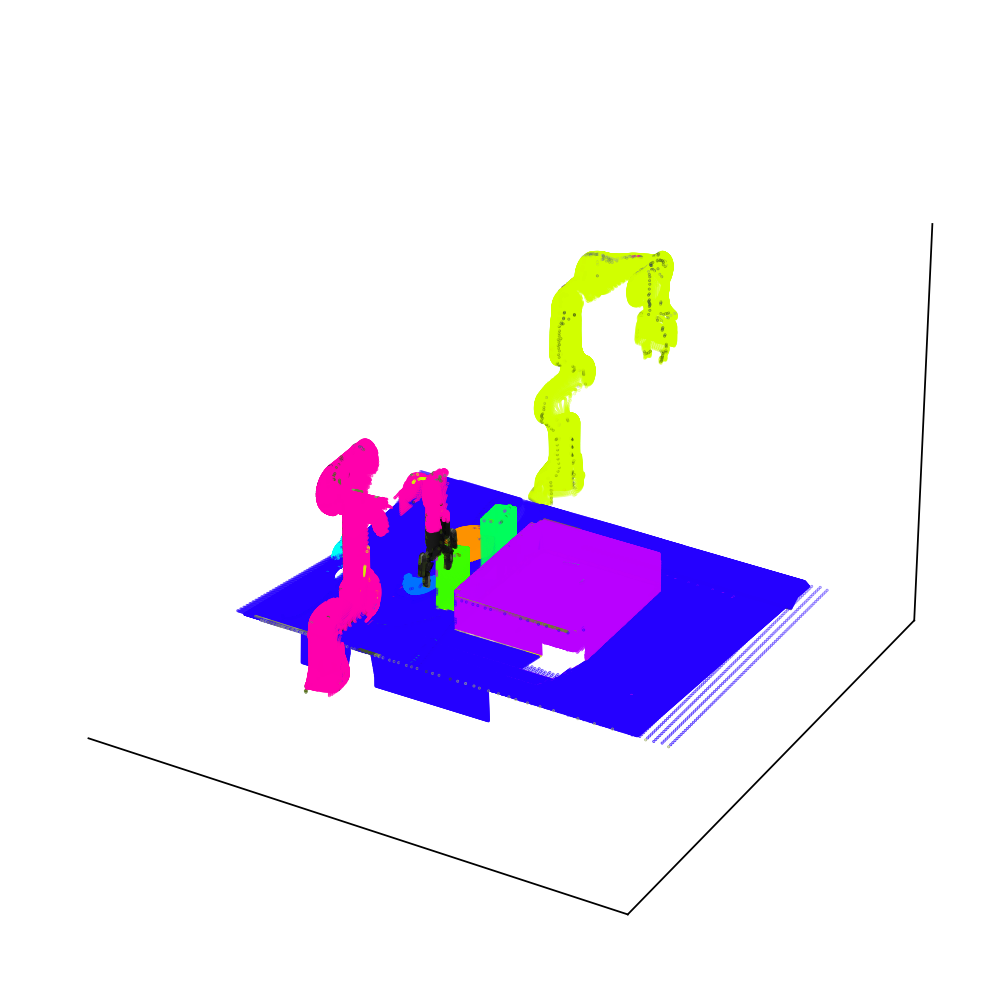

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_cloud(point_cloud, excluding=None, segmented=False):
    fig = plt.figure(figsize=(6, 6), dpi=160)
    ax = fig.add_subplot(111, projection="3d")
    background_color = (1.0, 1.0, 1.0)
    ax.set_facecolor(background_color)
    ax.w_xaxis.set_pane_color(background_color)  # type: ignore
    ax.w_yaxis.set_pane_color(background_color)  # type: ignore
    ax.w_zaxis.set_pane_color(background_color)  # type: ignore
    point_cloud = point_cloud.filter_bounds(bounds=SCENE_BOUNDS)

    xyz_pts = point_cloud.xyz_pts
    rgb_pts = point_cloud.rgb_pts/255.0

    # optionally exclude certain classes
    mask = np.ones(len(point_cloud), dtype=bool)
    if excluding is not None:
        for key, value in point_cloud.segmentation_pts.items():
            if key in excluding and np.any(value):
                mask &= ~value

        xyz_pts = xyz_pts[mask]
        rgb_pts = rgb_pts[mask]

    # changes the colors of the point cloud to correspond to object classes
    if segmented:
        num_classes = len(point_cloud.segmentation_pts.keys())
        colors = sns.color_palette("hsv", num_classes)
        for i, (key, value) in enumerate(point_cloud.segmentation_pts.items()):
            rgb_pts[value] = colors[i]

    x, y, z = (
        xyz_pts[mask, 0],
        xyz_pts[mask, 1],
        xyz_pts[mask, 2],
    )

    ax.scatter(
        x,
        y,
        z,
        c=rgb_pts.astype(float),
        s=pts_size,  # type: ignore
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([]) 
    ax.axes.set_xlim3d(left=SCENE_BOUNDS[0][0], right=SCENE_BOUNDS[1][0])  # type: ignore
    ax.axes.set_ylim3d(bottom=SCENE_BOUNDS[0][1], top=SCENE_BOUNDS[1][1])  # type: ignore
    ax.axes.set_zlim3d(bottom=SCENE_BOUNDS[0][2], top=SCENE_BOUNDS[1][2])  # type: ignore
    plt.tight_layout(pad=0)
    plt.show()

pts_size = 0.1
plot_class_cloud(global_point_cloud, excluding=None, segmented=True)

- Finally, we save the environment observation to use later.

In [15]:
from PIL import Image
import cv2
new_output = {}
for key in outputs:
    if key == "ur5e" or key == "panda": # these two cameras ended up sideways with how I had to orient them to capture the robotic arms
        img = cv2.rotate(outputs[key][1], cv2.ROTATE_90_COUNTERCLOCKWISE)
        depth_img = cv2.rotate(outputs[key][2], cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        img = outputs[key][1]
        depth_img = outputs[key][2]
        
    pose = outputs[key][0].pose
    new_output[key] = (img, depth_img)

# coming out of mujoco, the points are usually very small (on the order of [0,2]), which causes them to almost all become 0 when casting to long
# we scale up the values by a factor of 100 since empirically that proved to be a good scale in terms of number of points preserveed
# after converting to long without the dimensions starting to become too large
scaled_xyz_pts = global_point_cloud.xyz_pts * 100

new_output['xyz_pts'] = scaled_xyz_pts
new_output['segmentation_pts'] = global_point_cloud.segmentation_pts
new_output['rgb_pts'] = global_point_cloud.rgb_pts

import pickle

with open('outputs.pkl', 'wb') as f:
    pickle.dump(new_output, f)

took 0.006120443344116211 seconds to save the environment query
